Epoch 1, Loss: 5.20 %, Accuracy: 90.46 %


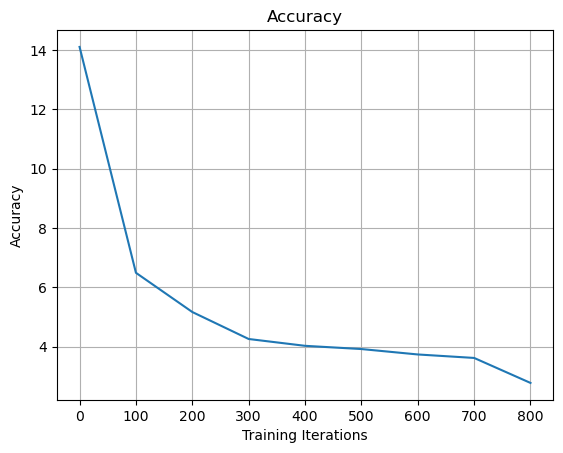

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
#descent de gradient avec momentum & data hiministe

def to_categorical(x, n_col=None):
    if not n_col:
        n_col = np.amax(x) + 1
    one_hot = np.zeros((x.shape[0], n_col))
    one_hot[np.arange(x.shape[0]), x] = 1
    return one_hot

def load_data():

    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    y_train, y_test = to_categorical(y_train.astype("int")), to_categorical(y_test.astype("int"))
    X_train, X_test = X_train / 255.0, X_test / 255.0
    X_train, X_test = X_train.reshape(-1, 28 * 28), X_test.reshape(-1, 28 * 28)
    return (X_train, y_train), (X_test, y_test)

(X_train, y_train), (X_test, y_test) = load_data()

def accuracy(y_true, y_pred):
  return np.sum(y_true == y_pred, axis=0) / len(y_true)

def batch_loader(X, y = None, batch_size=64):
  n_samples = X.shape[0]
  for i in np.arange(0, n_samples, batch_size):
    begin, end = i, min(i + batch_size, n_samples)
    if y is not None:
      yield X[begin:end], y[begin: end]
    else:
      yield X[begin:end]

def showGraph(cost):
    plt.grid()
    plt.plot([100 * val for val in range(len(cost))], cost)
    plt.title('Accuracy')
    plt.xlabel('Training Iterations')
    plt.ylabel('Accuracy')
    plt.show()

class CrossEntropy():
    def __init__(self): pass

    def loss(self, y, p):
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return -y * np.log(p) - (1 - y) * np.log(1 - p)

    def gradient(self, y, p):
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return -(y / p) + (1 - y) / (1 - p)
class Loss():
    def __init__(self): pass

    def loss(self, y, p):
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return (1/y.shape[0])*((y - p)**2)

    def gradient(self, y, p):
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return (y-p)/y.shape[0]



class LeakyReLU():
    def __init__(self, alpha=0.2):
        self.alpha = alpha

    def __call__(self, x):
        return self.activation(x)

    def activation(self, x):
        return np.where(x >= 0, x, self.alpha * x)

    def gradient(self, x):
        return np.where(x >= 0, 1, self.alpha)


class Softmax():
    def __init__(self): pass

    def __call__(self, x):
        return self.activation(x)

    def activation(self, x):
        e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return e_x / np.sum(e_x, axis=-1, keepdims=True)

    def gradient(self, x):
        p = self.activation(x)
        return p * (1 - p)


class Activation():

    def __init__(self, activation, name="activation"):
        self.activation = activation
        self.gradient = activation.gradient
        self.input = None
        self.output = None
        self.name = name

    def forward(self, x):
        self.input = x
        self.output = self.activation(x)
        return self.output

    def backward(self, output_error, lr=0.01):
        return self.gradient(self.input) * output_error

    def __call__(self, x):
        return self.forward(x)


class Linear():
    def __init__(self, n_in, n_out, name="linear"):
        limit = 1 / np.sqrt(n_in)
        self.W = np.random.uniform(-limit, limit, (n_in, n_out))
        self.b = np.zeros((1, n_out))  # Biases
        self.vw = np.zeros(self.W.shape)
        self.vb = np.zeros(self.b.shape)
        self.input = None
        self.output = None
        self.name = name

    def forward(self, x):
        self.input = x
        self.output = np.dot(self.input, self.W) + self.b  # Wx + b
        return self.output

    def backward(self, output_error, lr=0.01):
        input_error = np.dot(output_error, self.W.T)
        delta = np.dot(self.input.T, output_error)
        self.vw = 0.9 * self.vw + delta
        self.vb = 0.9 * self.vb + np.mean(output_error)
        self.W -= lr * self.vw
        self.b -= lr * self.vb

        return input_error

    def __call__(self, x):
        return self.forward(x)


class Network():
    def __init__(self, input_dim, output_dim, lr=0.01):
        # input_dim = 784, output_dim = 10 for mnist
        self.layers = [
            Linear(input_dim, 256, name="input"),
            Activation(LeakyReLU(), name="relu1"),
            Linear(256, 128, name="input"),
            Activation(LeakyReLU(), name="relu2"),
            Linear(128, output_dim, name="output"),
            Activation(Softmax(), name="softmax")
        ]
        self.lr = lr

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def backward(self, loss_grad):
        for layer in reversed(self.layers):
            loss_grad = layer.backward(loss_grad, self.lr)

    def __call__(self, x):
        return self.forward(x)

def train(n_input_dim, n_out,EPOCHS=5,  lr=1e-3):
    criterion = CrossEntropy()
    model = Network(n_input_dim, n_out, lr=1e-3)
    cost = []
    for epoch in range(EPOCHS):
        loss = []
        acc = []
        counter = 0
        for x_batch, y_batch in batch_loader(X_train, y_train):
            counter += 1
            out = model(x_batch)
            loss.append(np.mean(criterion.loss(y_batch, out)))
            acc.append(accuracy(np.argmax(y_batch, axis=1), np.argmax(out, axis=1)))
            if counter % 100 == 0:
                tmp = np.array(loss)
                cost.append(100*np.mean(tmp[counter-100: counter]))
            error = criterion.gradient(y_batch, out)
            model.backward(error)
        print(f"Epoch {epoch + 1}, Loss: {np.mean(loss)*100:.2f} %, Accuracy: {np.mean(acc)*100:.2f} %")
    return model, cost

def test(model, X, y):
    print("-------- Test --------")
    for i, val in enumerate(X):
        out = model(val)
        y_target = np.argmax(y[i])
        y_predict = np.argmax(out)
        print(f"y_predict: {y_predict} ---- y: {y_target}")
    acc = accuracy(np.argmax(y, axis=1), np.argmax(model(X), axis=1))*100
    print("----------------------")
    print(f"Test Accuracy: {acc:.2f} %")


n_input_dim = 28*28 # 784
n_out = 10 # 10 classes
model, cost = train(n_input_dim, n_out, 1, 0.01)
showGraph(cost)
